# Set up

## Downloads
* Please access TLC record data website (https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page) and download the following datasets:
    * (1) "Yellow Taxi Trip Records" January, 2022
    * (2) "Yellow Taxi Trip Records" June, 2022
    * (3) Taxi zone lookup table

## Imports

In [38]:
#!pip install pyarrow

In [39]:
import numpy as np
import pandas as pd
import os

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
import pyarrow.parquet as pq # .csv 데이터는 읽는 것보다 쓰는 데 매우 시간이 많이 걸린다. arrow에서는 csv 포맷을 지원하지 않으므로, parquet 타입 파일을 활용해야 한다.

## Load Dataset

In [41]:
data_dir = 'D:/OneDrive - 연세대학교 (Yonsei University)/Lectures/2022-2_모빌리티데이터분석및활용/dataset/TLC_record'

In [42]:
data_jan = 'yellow_tripdata_2022-01.parquet'
data_jun = 'yellow_tripdata_2022-06.parquet'
data_zone = 'taxi+_zone_lookup.csv'

In [43]:
path_jan = os.path.join(data_dir, data_jan)
path_jun = os.path.join(data_dir, data_jun)
path_zone = os.path.join(data_dir, data_zone)

In [44]:
df_jan = pd.read_parquet(path_jan, engine = 'pyarrow')
df_jun = pd.read_parquet(path_jun, engine = 'pyarrow')

df_jan.reset_index(inplace = True)
df_jun.reset_index(inplace = True)

df_jan.rename(columns = {'index': 'Num'}, inplace = True)
df_jun.rename(columns = {'index': 'Num'}, inplace = True)

In [45]:
df_jan.head(3)

,Num,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0


In [46]:
df_zone = pd.read_csv(path_zone)

In [47]:
df_zone.head(3)

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone


In [48]:
color_theme = ['#6f57ef', '#57efbb'] # violet, mint

# Q1) Find the largest demand of the yellow taxi at New York in January 2022 in terms of:
* (1) Pick-up location (i.e. zone)
* (2) Drop-off location
* (3) Origin-destination (i.e. from a pick-up zone to drop-off zone)

## Merge Dataframes : Taxi + Zone
* Taxi 데이터프레임과 Zone 데이터프레임을 Merge
* 기점코드(`PULocationID`), 종점코드(`DOLocationID`)에 대한 정보를 Zone 정보와 통합하여 한 데이터프레임으로 나타냄
    * `PULocationID` : TLC Taxi zone in which the taximeter was engaged
    * `DOLocationID` : TLC Taxi Zone in which the taximeter was disengaged

In [49]:
merged_jan = pd.merge(df_jan, df_zone, how = 'left', left_on = 'PULocationID', right_on = 'LocationID')
merged_jan.rename(columns = {'Borough': 'PU_Borough', 'Zone': 'PU_Zone', 'service_zone': 'PU_service_zone'}, inplace = True)

In [50]:
merged_jan = pd.merge(merged_jan, df_zone, how = 'left', left_on = 'DOLocationID', right_on = 'LocationID')
merged_jan.rename(columns = {'Borough': 'DO_Borough', 'Zone': 'DO_Zone', 'service_zone': 'DO_service_zone'}, inplace = True)

In [51]:
merged_jan.drop(['LocationID_x', 'LocationID_y'], axis = 'columns', inplace = True)

In [52]:
merged_jan.head(3)

,Num,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,PU_Borough,PU_Zone,PU_service_zone,DO_Borough,DO_Zone,DO_service_zone
0,0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,...,0.3,21.95,2.5,0.0,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Upper East Side North,Yellow Zone
1,1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,...,0.3,13.30,0.0,0.0,Manhattan,Upper East Side North,Yellow Zone,Manhattan,Central Harlem North,Boro Zone
2,2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,...,0.3,10.56,0.0,0.0,Manhattan,Morningside Heights,Boro Zone,Manhattan,Morningside Heights,Boro Zone


## (1) The largest demand of pick-up location
* i.e. zone
* pick-up location(탑승 존)을 찾기 위해서 `PU_Zone` 컬럼을 이용

### Make pivot table

In [53]:
pv_pickup = pd.pivot_table(merged_jan, index = 'PU_Zone', values = 'Num', aggfunc = 'count')

In [54]:
pv_pickup.sort_values(by = 'Num', ascending = False, inplace = True)

In [55]:
pv_pickup

,Num
PU_Zone,
Upper East Side South,121630
Upper East Side North,120814
JFK Airport,103485
Midtown Center,88237
Penn Station/Madison Sq West,80580
...,...
Oakwood,1
Governor's Island/Ellis Island/Liberty Island,1
New Dorp/Midland Beach,1


### Answer
* The largest demand among the pick-up locations is **'Upper East Side South'** Zone.
* The number of demand is 121,630.

## (2) The largest demand of drop-off location

### Make pivot table

In [56]:
pv_dropoff = pd.pivot_table(merged_jan, index = 'DO_Zone', values = 'Num', aggfunc = 'count')

In [57]:
pv_dropoff.sort_values(by = 'Num', ascending = False, inplace = True)

In [58]:
pv_dropoff

,Num
DO_Zone,
Upper East Side North,123470
Upper East Side South,106355
Lenox Hill West,78341
Upper West Side South,75050
Midtown Center,74707
...,...
Port Richmond,12
Rossville/Woodrow,9
Jamaica Bay,5


### Answer
* The largest demand among the drop-off locations is **'Upper East Side North'** Zone. 
* The number of demand is 123,470.

## (3) The largest demand of Origin-destination
* i.e. from a pick-up zone to drop-off zone

### Make OD column
* Origin-destination 컬럼 `OD`생성하기

In [59]:
merged_jan['OD'] = merged_jan['PU_Zone'] + '-' + merged_jan['DO_Zone']

### Make pivot table

In [60]:
pv_OD = pd.pivot_table(merged_jan, index = 'OD', values = 'Num', aggfunc = 'count')

In [61]:
pv_OD.sort_values(by = 'Num', ascending = False, inplace = True)

In [62]:
pv_OD

,Num
OD,
Upper East Side South-Upper East Side North,18749
Upper East Side North-Upper East Side South,16200
Upper East Side North-Upper East Side North,13871
Upper East Side South-Upper East Side South,12149
NV-NV,10811
...,...
Co-Op City-Flatlands,1
Co-Op City-Fordham South,1
Co-Op City-Fresh Meadows,1


### Answer
* The largest demand of Origin-Destination is **Upper East Side South** zone to **Upper East Side North** zone.
* The number of that demand is 18,749.

# Q2) Compare the yellow taxi data between January 2022 and June 2022 in terms of:
* (1) Total demand (i.e. the number of passengers)
* (2) Average trip distance per ride
* (3) Distribution of demand across time of day

## (1) Total demand
* i.e. the number of passengers
* Using `passenger_count` column

In [63]:
total_demand = pd.Series([int(df_jan['passenger_count'].sum()), int(df_jun['passenger_count'].sum())], index = ['January', 'June'])

In [64]:
total_demand

January    3324167
June       4792664
dtype: int64

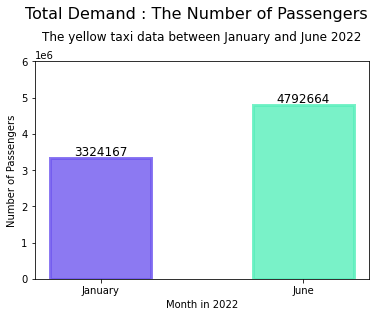

In [65]:
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1)

axis.bar( # Draw bar graph
    x = total_demand.index, 
    height = total_demand.values,
    color = color_theme,
    alpha = 0.8,
    edgecolor = color_theme,
    linewidth = 3,
    width = 0.5
)

plt.ylim([0, 6000000])

for i in range(len(total_demand.index)):
    height = total_demand.values[i]
    plt.text(total_demand.index[i], height + 0.05, '%.0f' %height, ha = 'center', va = 'bottom', size = 12)

# Graph Title and Label Setting
plt.suptitle('Total Demand : The Number of Passengers', fontsize = 16, y = 1.07) # 그래프 전체에 대한 Title
plt.title('The yellow taxi data between January and June 2022', fontsize = 12, y = 1.07) # 그래프 전체에 대한 Title

axis.set_xlabel('Month in 2022')
axis.set_ylabel('Number of Passengers')


# Show Graph
plt.show()

* The number of passengers in january 2022 is 3,324,167.
* The number of passengers in june 2022 is 4,792,664.
* The demand of june 2022 is larger than january 2022's.

## (2) Average trip distance per ride

In [66]:
avg_trip_distance = pd.Series([df_jan['trip_distance'].mean(), df_jun['trip_distance'].mean()], index = ['January', 'June'])

In [67]:
avg_trip_distance

January    5.372751
June       5.968216
dtype: float64

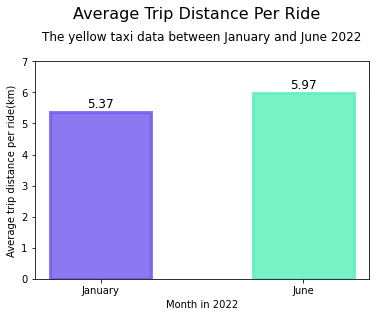

In [68]:
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1)

axis.bar( # Draw bar graph
    x = avg_trip_distance.index, 
    height = avg_trip_distance.values,
    color = color_theme,
    alpha = 0.8,
    edgecolor = color_theme,
    linewidth = 3,
    width = 0.5
)

plt.ylim([0, 7])

for i in range(len(avg_trip_distance.index)):
    height = avg_trip_distance.values[i]
    plt.text(avg_trip_distance.index[i], height + 0.05, '%.2f' %height, ha = 'center', va = 'bottom', size = 12)

# Graph Title and Label Setting
plt.suptitle('Average Trip Distance Per Ride', fontsize = 16, y = 1.07) # 그래프 전체에 대한 Title
plt.title('The yellow taxi data between January and June 2022', fontsize = 12, y = 1.07) # 그래프 전체에 대한 Title

axis.set_xlabel('Month in 2022')
axis.set_ylabel('Average trip distance per ride(km)')

# Show Graph
plt.show()

* The average trip distance per ride in january 2022 is about 5.37km.
* The average trip distance per ride in january 2022 is about 5.97km.
* The average trip distance per ride in june 2022 is 0.6km longer than january 2022's.

## (3) Distributions of demand across time of day

### Parse hour from datetime 
* `df['A'].dt.hour` : 시(숫자)

In [69]:
df_jan['PU_hour'] = df_jan['tpep_pickup_datetime'].dt.hour
df_jun['PU_hour'] = df_jun['tpep_pickup_datetime'].dt.hour

In [70]:
df_jan.head(3)

,Num,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,PU_hour
0,0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,...,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0,0
1,1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,...,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0,0
2,2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,...,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0,0


### Draw distributions of demand across time of day

C:\dev\Anaconda_3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\dev\Anaconda_3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


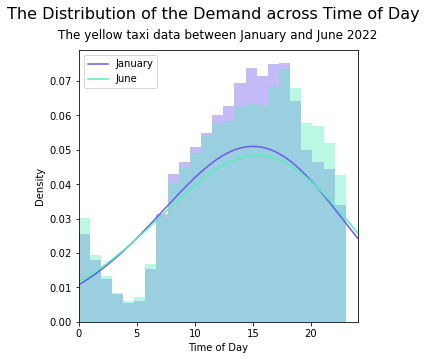

In [71]:
# Drawing Density Plot
fig, ax = plt.subplots(figsize = (5 , 5))

sns.distplot(df_jan['PU_hour'], bins = 24, color = color_theme[0], kde_kws = {'bw_method' : 1})
sns.distplot(df_jun['PU_hour'], bins = 24, color = color_theme[1], kde_kws = {'bw_method' : 1})

plt.xlim([0, 24])

# Graph Title and Label Setting
plt.suptitle('The Distribution of the Demand across Time of Day', fontsize = 16, y = 1) # 그래프 전체에 대한 Title
plt.title('The yellow taxi data between January and June 2022', fontsize = 12, y = 1.02) # 그래프 전체에 대한 Title

ax.set_xlabel('Time of Day')
ax.set_ylabel('Density')

# Add legend
plt.legend(labels = ['January', 'June'])

# Show Graph
plt.show()

* January's distribution of the demand across time of day is different from june's.
* The distribution of january have peak point at 14 ~ 15 O'clock.
* But the distribution of june have peak point at 15 ~ 16 O'clock.